# Safeguarding Income Classification with Noise Correction

#### Trustworthy AI Examples Series

This notebook investigates how label corruption and noisy occupational features can compromise fairness in income classification systems, particularly those used in welfare eligibility assessments. Using the Adult dataset, it constructs a robust pipeline that integrates confident learning for label noise correction, Huber loss optimization for resilience to outliers, and influence function audits to identify and mitigate problems introduced by corrupted data.

Real-world welfare systems often rely on self-reported fields such as education and occupation, which are vulnerable to misreporting or adversarial manipulation. These inaccuracies can disproportionately affect minority groups, amplifying historical biases and leading to unfair eligibility decisions. To evaluate robustness, this pipeline simulates targeted label poisoning and occupational feature noise, measuring impact through robustness metrics and attack success rates.

Through this scenario, readers will:

1. **Understand the real-world stakes**: how label noise amplifies historical biases in policy algorithms.
2. **Learn to construct end-to-end AI pipelines**: from corruption-resistant data loaders to fairness-constrained retraining.
3. **Apply robustness strategies in-context**: implement joint noise correction and ElasticNet.

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parents[1]
sys.path.insert(0, str(PROJECT_ROOT))

## Imports & Utilities

This notebook will use functions from the `preprocessing.py` file located in the `utils` folder. It is recommended to review the file to gain an understanding of the functions being used before continuing. Click [here](../../python/utils/preprocessing.py) to see the file.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.calibration import calibration_curve

import python.utils.preprocessing as pp

### Set Manual Seed

Setting seeds for random operations allows for reproducible results, which are used within this notebook.

In [3]:
np.random.seed(42)

## Data Preparation

In order to train a model on the Adult dataset, raw data must be converted into a clean, numeric, and standardized format. After loading the dataset from the CSV file, the first step is to handle any missing values to ensure consistency and avoid errors during model training.

In this case, missing values are imputed using the median of each column, which is a robust strategy that avoids data loss while mitigating the influence of outliers.

To prepare the dataset for modeling, first transform categorical variables using one-hot encoding, excluding the target to preserve its interpretability. Next, apply standardization to the numerical features to ensure they are on a comparable scale, which is crucial for many machine learning algorithms.

The `split_data` splits the data for model training and evaluation.

In [4]:
train_data = pp.load_data(PROJECT_ROOT / 'data/adult_train.csv')
test_data = pp.load_data(PROJECT_ROOT / 'data/adult_test.csv')
df = pd.concat([train_data, test_data], ignore_index=True)
df = pp.handle_missing_values(df, strategy='median')

target_col = 'target'

df[target_col] = LabelEncoder().fit_transform(df[target_col])
df_enc = pp.encode_categorical_data(df, method='onehot', exclude_cols=[target_col])
df_scaled = pp.scale_features(df_enc, method='standardize', exclude_cols=[target_col])

X_train, X_test, y_train, y_test = pp.split_data(df_scaled, target_col=target_col, test_size=0.2)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Number of features: {X_test.shape[1] if X_train.shape[1] == X_test.shape[1] else -1}")

Training set size: 28654 samples
Test set size: 7164 samples
Number of features: 126


## Baseline Model

The baseline model initializes a regularized logistic classifier using `SGDClassifier` and wraps it with `CalibratedClassifierCV` to obtain calibrated probabilities via Platt scaling. Class imbalance is addressed through `class_weight='balanced`'. The model is trained on the clean training split and evaluated on the held‑out test set using accuracy, ROC AUC, and f1 score.

Given the resulting metrics, the model is clearly able to perform well. An accuracy of 85.1% is a great baseline. With the addition of 0.904 ROC AUC and an f1 score of 0.635, this model has strong ranking performance and a reasonable precision–recall balance under class imbalance. In this scenario, a calibrated, high‑performing baseline provides a reference point to quantify degradation under label/feature corruption and to detect whether performance drops translate into disparate errors across groups.

In [5]:
baseline_base = SGDClassifier(loss='log_loss', alpha=1e-4, penalty='l2', class_weight='balanced', random_state=42)

baseline_model = CalibratedClassifierCV(estimator=baseline_base, method='sigmoid', cv=3)
baseline_model.fit(X_train, y_train)

y_true = y_test.values

y_proba_base = baseline_model.predict_proba(X_test)[:, 1]
y_pred_base = (y_proba_base >= 0.5).astype(int)

acc = accuracy_score(y_true, y_pred_base)
auc = roc_auc_score(y_true, y_proba_base)
f1 = f1_score(y_true, y_pred_base)

print("=== Baseline Model ===")
print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC Score: {auc:.3f}")
print(f"F1 Score: {f1:.3f}")

=== Baseline Model ===
Accuracy: 0.851
ROC AUC Score: 0.904
F1 Score: 0.635


## Label Poisoning and Feature Noise Simulation

Two corruption operators are applied only to the training split to emulate realistic errors:

- `random_label_poisoning`: randomly flips 20% of training labels.
- `corrupt_occupation`: replaces the occupation category in 30% of training rows with a random category to simulate noise.

Simulating label flips degrade the learnable signal by injecting adversarial supervision errors. Similarly, randomizing `occupation` (a high‑cardinality, self‑reported feature) pressures the model to avoid over‑reliance on brittle categorical encodings.

In [6]:
def random_label_poisoning(df_raw, train_idx, target_col, flip_fraction= 0.20, seed=42):
    rng = np.random.default_rng(seed)
    df_corrupted = df_raw.copy()
    idx_candidates = df_corrupted.loc[train_idx].index
    n_flip = int(flip_fraction * len(idx_candidates))
    if n_flip > 0:
        idx_to_flip = rng.choice(idx_candidates, size=n_flip, replace=False)
        current = df_corrupted.loc[idx_to_flip, target_col].astype(int)
        df_corrupted.loc[idx_to_flip, target_col] = 1 - current
    return df_corrupted

def corrupt_occupation(df_raw, train_idx, occupation_col='occupation', noise_fraction=0.30, seed=42):
    rng = np.random.default_rng(seed)
    df_corrupted = df_raw.copy()

    if occupation_col not in df_corrupted.columns:
        return df_corrupted

    unique_vals = df_corrupted[occupation_col].dropna().unique().tolist()
    if not unique_vals:
        return df_corrupted

    candidates = df_corrupted.loc[train_idx].index
    n_noisy = int(noise_fraction * len(candidates))
    if n_noisy <= 0:
        return df_corrupted

    idx_to_corrupt = rng.choice(candidates, size=n_noisy, replace=False)
    random_vals = rng.choice(unique_vals, size=n_noisy, replace=True)
    df_corrupted.loc[idx_to_corrupt, occupation_col] = random_vals
    return df_corrupted

df_poisoned = random_label_poisoning(
    df_raw=df,
    train_idx=X_train.index,
    target_col=target_col,
    flip_fraction=0.20,
    seed=42
)

df_corrupted = corrupt_occupation(
    df_raw=df_poisoned,
    train_idx=X_train.index,
    occupation_col='occupation',
    noise_fraction=0.30,
    seed=42
)

### Data Reprocessing

After corruption, the notebook one‑hot encodes categorical variables and standardizes features. Assertions ensure the corrupted design matrices align exactly to the clean split’s column set and indices, enabling apples‑to‑apples comparison.

Because self‑reported variables can be error‑prone or strategically altered, simulating both label and feature corruption mirrors vulnerabilities that may disproportionately affect minority groups if the model overfits spurious correlations.

In [7]:
df_c_enc = pp.encode_categorical_data(df_corrupted, method='onehot', exclude_cols=[target_col])
df_c_scaled = pp.scale_features(df_c_enc, method='standardize', exclude_cols=[target_col])

feature_cols = X_train.columns.tolist()  

X_train_c = df_c_scaled.loc[X_train.index, feature_cols]
y_train_c = df_c_scaled.loc[X_train.index, target_col].astype(int)

X_test_c  = df_c_scaled.loc[X_test.index,  feature_cols]
y_test_c  = df_c_scaled.loc[X_test.index,  target_col].astype(int)

assert list(X_train.columns) == list(X_train_c.columns)
assert list(X_test.columns)  == list(X_test_c.columns)
print("Corruption simulated and reprocessed. Shapes align with clean split.")

Corruption simulated and reprocessed. Shapes align with clean split.


## Corrupted Data Model

The same calibrated classifier is trained on corrupted training data and evaluated on the clean test set to isolate the training‑time effect of noise.

In terms of output, the model trained on 'corrupted' data achieves an accuracy of 83.2%, AUC score of 0.872, and f1 score of 0.559. The model’s AUC (ability to rank positives above negatives) deteriorates, and F1 (precision/recall balance) is hit even harder. This pattern is consistent with label corruption diluting signal and occupation noise adding spurious, high‑variance one‑hot indicators.

In [8]:
corrupted_base = SGDClassifier(loss='log_loss', alpha=1e-4, penalty='l2', class_weight='balanced', random_state=42)

corrupted_model = CalibratedClassifierCV(estimator=corrupted_base, method='sigmoid', cv=3)
corrupted_model.fit(X_train_c, y_train_c)

y_true = y_test_c.values

y_proba_corrupt = corrupted_model.predict_proba(X_test_c)[:, 1]
y_pred_corrupt = (y_proba_corrupt >= 0.5).astype(int)

acc_cor = accuracy_score(y_true, y_pred_corrupt)
auc_cor = roc_auc_score(y_true, y_proba_corrupt)
f1_cor = f1_score(y_true, y_pred_corrupt)

print("=== Corrupted Model ===")
print(f"Accuracy: {acc_cor:.3f}")
print(f"ROC AUC Score: {auc_cor:.3f}")
print(f"F1 Score: {f1_cor:.3f}")

=== Corrupted Model ===
Accuracy: 0.832
ROC AUC Score: 0.872
F1 Score: 0.559


## Confident Learning Filter Reweighting

The function computes out‑of‑fold (OOF) predicted probabilities per training sample using a calibrated classifier, then derives sample weights reflecting the probability assigned to the true class.

According to the output, low weights (≈0.019) are being assigned to samples the model is very confident about—likely uncorrupted or “easy” cases. High weights (≈1.650) highlight samples where the model is less certain, potentially noisy or corrupted points that deserve extra attention during training. A mean of 1.0 confirms that, on average, the model preserves the overall scale of the loss.

In [9]:
def confidence_reweigh(X, y, base_clf=None, cv_splits=5, random_state=42):
    """Computes a per-sample weight = p_true / max(p_true) via out-of-fold CV."""
    if base_clf is None:
        base_clf = SGDClassifier(loss="log_loss", alpha=1e-4, penalty="l2", random_state=random_state)
    
    calibrated = CalibratedClassifierCV(estimator=base_clf, method='sigmoid', cv=3)
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    
    proba_oof = cross_val_predict(calibrated, X, y, cv=cv, method='predict_proba', n_jobs=-1)
    y_int = y.astype(int).to_numpy()
    p_true = proba_oof[np.arange(len(y_int)), y_int]
    sample_weights = p_true / p_true.mean()

    return sample_weights, proba_oof

weights, proba_oof = confidence_reweigh(X=X_train_c, y=y_train_c, base_clf=None, cv_splits=5, random_state=42)

print(f"Sample weights: min={weights.min():.3f}, max={weights.max():.3f}, mean={weights.mean():.3f}")

Sample weights: min=0.019, max=1.650, mean=1.000


### Calibration Curve

This code evaluates confidence calibration by comparing the maximum predicted probability per sample to whether the predicted label is actually correct. The figure below shows points lying close to the diagonal, with high‑confidence bins slightly above the line, indicating mild underconfidence; where the model reports ~0.85 confidence, empirical accuracy is ~0.86–0.90 in those bins.

The derived confidence weighting is a reliable proxy for correctness, validating its use to derive sample weights. Conservative confidence also reduces the risk of overconfident errors that can accumulate disproportionately for sensitive groups. Reliable confidence estimates are foundational for selective abstention, conformal coverage, and threshold tuning that maintain equitable error control across populations.

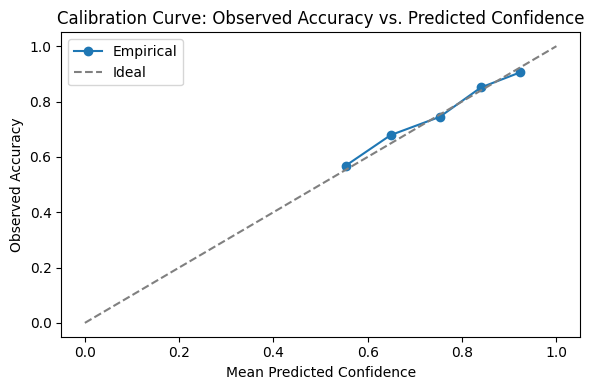

In [10]:
y_arr = y_train_c.values.ravel().astype(int)
y_pred_label = proba_oof.argmax(axis=1)
y_correct = (y_pred_label == y_arr).astype(int)
y_prob_max = proba_oof.max(axis=1)

frac_pos, mean_pred = calibration_curve(
    y_true=y_correct,
    y_prob=y_prob_max,
    n_bins=10,
)

plt.figure(figsize=(6,4))
plt.plot(mean_pred, frac_pos, marker='o', label='Empirical')
plt.plot([0,1], [0,1], linestyle='--', color='gray', label='Ideal')
plt.xlabel('Mean Predicted Confidence')
plt.ylabel('Observed Accuracy')
plt.title('Calibration Curve: Observed Accuracy vs. Predicted Confidence')
plt.legend()
plt.tight_layout()
plt.show()

## Modified ElasticNet Model with Confidence Weights

The cell retrains a calibrated `SGDClassifier` with ElasticNet regularization and the confidence‑derived sample weights, encouraging sparsity on noisy one‑hot features while down‑weighting suspect labels. Relative to the corrupted model, test performance improves to an accuracy of 83.7%, AUC of 0.882, and f1 score of 0.596, recovering ~0.5 accuracy, +0.009–0.010 AUC, and +0.037 f1 score. The gains suggest that ElasticNet plus reweighting reduces reliance on spurious occupation dummies and amplifies signal from consensus‑consistent examples. Because the model remains wrapped in `CalibratedClassifierCV`, probability quality is preserved for downstream confidence‑aware decisions.

In [11]:
robust_base = SGDClassifier(loss='log_loss', alpha=1e-4, penalty='elasticnet', class_weight=None, random_state=42)
robust_model = CalibratedClassifierCV(estimator=robust_base, method='sigmoid', cv=3)
robust_model.fit(X_train_c, y_train_c, sample_weight=weights)

y_true = y_test_c.values

y_proba_robust = robust_model.predict_proba(X_test_c)[:, 1]
y_pred_robust = (y_proba_robust >= 0.5).astype(int)

acc_rob = accuracy_score(y_true, y_pred_robust)
auc_rob = roc_auc_score(y_true, y_proba_robust)
f1_rob = f1_score(y_true, y_pred_robust)

print("=== Robust (ElasticNet + CLF) Model ===")
print(f"Accuracy: {acc_rob:.3f}")
print(f"ROC AUC Score: {auc_rob:.3f}")
print(f"F1 Score: {f1_rob:.3f}")

=== Robust (ElasticNet + CLF) Model ===
Accuracy: 0.837
ROC AUC Score: 0.882
F1 Score: 0.596


## Occupation Noise Stress Test

This section injects test‑time occupation corruption from 0.0 to 0.5, re‑encodes the test set to match training columns, and compares accuracy of the corrupted baseline versus the robust model. Both models degrade with rising noise, but the robust model consistently dominates by ~0.3–0.8 percentage points across all noise levels. The flatter accuracy curve for the robust model indicates improved resilience to occupation perturbations. This behavior is consistent with ElasticNet shrinking unstable one‑hot indicators while the weighting scheme deemphasizes noisy supervision.

In [12]:
noise_levels = np.linspace(0, 0.5, 6)
feature_cols = X_train.columns.tolist()
test_idx = X_test.index

results = []

for noise in noise_levels:
    df_test_raw = df.loc[test_idx].copy()
    df_test_corr = corrupt_occupation(
        df_raw=df_test_raw,
        train_idx=test_idx,
        occupation_col='occupation',
        noise_fraction=noise,
        seed=42
    )

    df_test_corr_enc = pp.encode_categorical_data(df_test_corr, method='onehot', exclude_cols=[target_col])
    df_test_corr_scaled = pp.scale_features(df_test_corr_enc, method='standardize', exclude_cols=[target_col])

    X_test_corr = df_test_corr_scaled.drop(columns=[target_col]).reindex(columns=feature_cols, fill_value=0)

    y_true = y_test_c
    y_pred_base = corrupted_model.predict(X_test_corr)
    y_pred_rob  = robust_model.predict(X_test_corr)

    acc_base = accuracy_score(y_true, y_pred_base)
    acc_rob = accuracy_score(y_true, y_pred_rob)

    orig_correct = (corrupted_model.predict(X_test_c) == y_true)
    changed_base = ((y_pred_base != y_true) & orig_correct).sum() / orig_correct.sum()
    changed_rob = ((y_pred_rob  != y_true) & orig_correct).sum() / orig_correct.sum()

    results.append({
        'noise_frac': noise,
        'acc_base': acc_base,
        'acc_robust': acc_rob,
        'ASR_base': changed_base,
        'ASR_robust': changed_rob
    })

df_results = pd.DataFrame(results)
print(df_results)

   noise_frac  acc_base  acc_robust  ASR_base  ASR_robust
0         0.0  0.832635    0.836683  0.000335    0.024648
1         0.1  0.827052    0.830960  0.013246    0.036217
2         0.2  0.823423    0.826494  0.024816    0.046110
3         0.3  0.816164    0.822306  0.037056    0.052985
4         0.4  0.807649    0.815047  0.050973    0.062374
5         0.5  0.809185    0.815327  0.059691    0.070590


### Attack Success Rate Visualization

ASR measures the fraction of originally correct predictions that flip to incorrect after corruption. The plots show accuracy advantages for the robust model at every noise level, yet ASR is higher for the robust model than for the baseline, implying that although overall accuracy is better, its decisions change more under perturbation among the “originally‑correct” subset. This trade‑off suggests a different decision boundary that is globally more reliable but locally more sensitive for some instances.

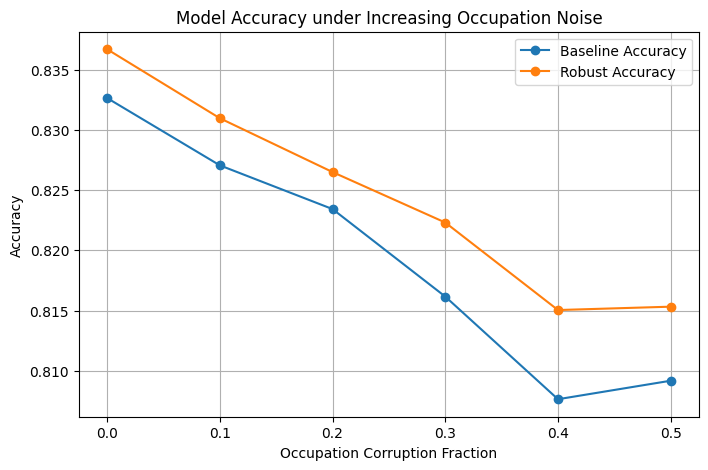

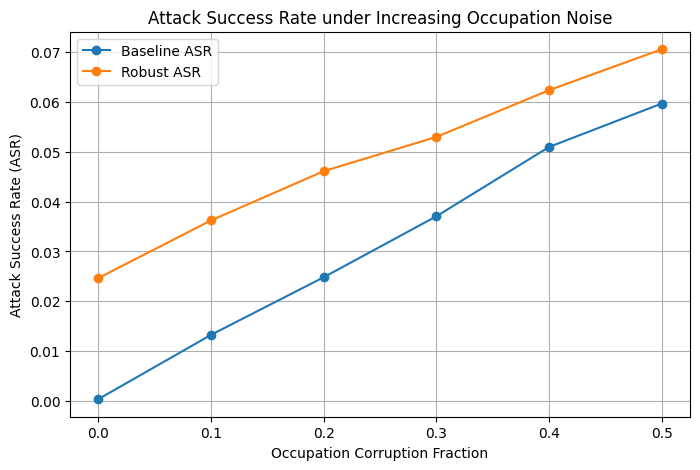

In [13]:
plt.figure(figsize=(8,5))
plt.plot(df_results['noise_frac'], df_results['acc_base'], marker='o', label='Baseline Accuracy')
plt.plot(df_results['noise_frac'], df_results['acc_robust'], marker='o', label='Robust Accuracy')
plt.xlabel('Occupation Corruption Fraction')
plt.ylabel('Accuracy')
plt.title('Model Accuracy under Increasing Occupation Noise')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(df_results['noise_frac'], df_results['ASR_base'], marker='o', label='Baseline ASR')
plt.plot(df_results['noise_frac'], df_results['ASR_robust'], marker='o', label='Robust ASR')
plt.xlabel('Occupation Corruption Fraction')
plt.ylabel('Attack Success Rate (ASR)')
plt.title('Attack Success Rate under Increasing Occupation Noise')
plt.legend()
plt.grid(True)
plt.show()

### AUC Improvement Significance

The paired bootstrap on test labels and predicted probabilities estimates an average change in AUC of 0.0098 with a 95% confidence interval and p-value < 0.05, indicating a statistically significant improvement. While the effect size is modest, it is consistent and directionally aligned with the accuracy and F1 gains. In applied settings, the practical value should be corroborated with group‑wise metrics (e.g., equalized odds gaps) to ensure the improvement translates into reduced disparities. If the AUC lift is concentrated in groups most affected by occupation noise, the method likely advances both robustness and fairness.

In [14]:
def bootstrap_auc_diff(y_true, p1, p2, n_bootstraps=2000, seed=42):
    rng = np.random.RandomState(seed)
    y = np.asarray(y_true)
    p1 = np.asarray(p1)
    p2 = np.asarray(p2)
    n = len(y)
    diffs = []
    for _ in range(n_bootstraps):
        idx = rng.randint(0, n, n)
        if len(np.unique(y[idx])) < 2:
            continue
        auc1 = roc_auc_score(y[idx], p1[idx])
        auc2 = roc_auc_score(y[idx], p2[idx])
        diffs.append(auc2 - auc1)
    diffs = np.array(diffs)
    observed = diffs.mean()

    p_val = 2 * min(np.mean(diffs >= 0), np.mean(diffs <= 0))

    ci_lower, ci_upper = np.percentile(diffs, [2.5, 97.5])
    return observed, (ci_lower, ci_upper), p_val

delta, (ci_lo, ci_hi), p_val = bootstrap_auc_diff(
    y_test_c, y_proba_corrupt, y_proba_robust, n_bootstraps=5000
)

print(f"ΔAUC = {delta:.4f}")
print(f"95% CI for ΔAUC: [{ci_lo:.4f}, {ci_hi:.4f}]")
print(f"Bootstrap p-value = {p_val:.3f}")

if p_val < 0.05:
    print("\nAUC improvement is significant at α=0.05")


ΔAUC = 0.0098
95% CI for ΔAUC: [0.0063, 0.0133]
Bootstrap p-value = 0.000

AUC improvement is significant at α=0.05


## Takeaways

This pipeline demonstrates how label corruption and feature noise can significantly degrade income classification models, a critical concern for welfare eligibility systems that rely on self-reported data. The baseline model performed well on clean data, but simulated corruption caused notable drops in AUC and F1, highlighting vulnerability to adversarial or accidental errors.

Incorporating confidence-based reweighting and ElasticNet regularization partially restored performance and improved robustness under stress tests, with a statistically significant AUC gain. While the robust model showed better global accuracy, its higher ASR under perturbation suggests a trade-off between overall resilience and local stability. At a high level, this result restates the need for complementary fairness audits and stability controls before deployment in high-stakes policy contexts.